In [117]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage


# Import data

In [118]:
df_rfm = pd.read_csv('/Users/phungtran/Library/Mobile Documents/com~apple~CloudDocs/Documents/Learning/Data_science/DL07_graduation/project1/ML_graduation_projects/df_RFM.csv')
df_rfm = df_rfm[['Member_number', 'Recency', 'Frequency', 'Monetary']]
df_rfm.head()

,Member_number,Recency,Frequency,Monetary
0,2193,91,21,361.45
1,1793,26,19,345.10
2,3289,4,21,334.15
3,2433,3,24,316.81
4,2743,142,15,312.46


# Remove outliers

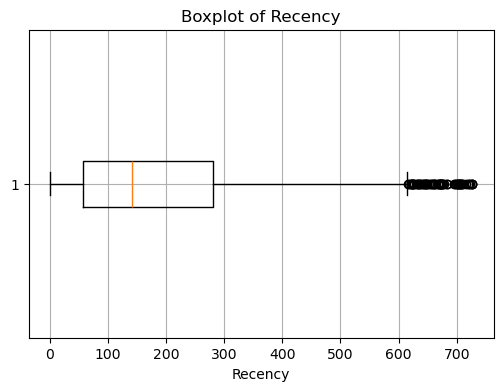

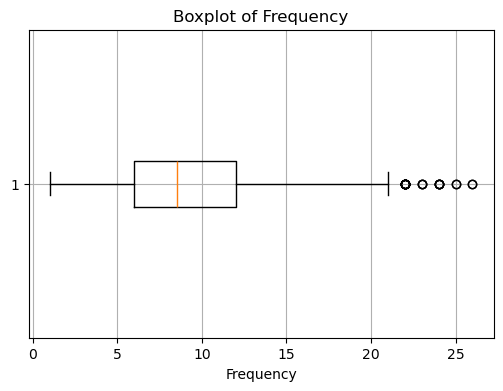

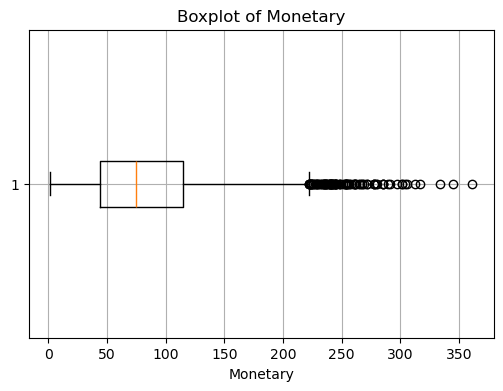

In [119]:
def plot_box(df, col):
    plt.figure(figsize=(6, 4))
    plt.boxplot(df[col], vert=False)
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.grid(True)
    plt.show()
    
plot_box(df_rfm, 'Recency')
plot_box(df_rfm, 'Frequency')
plot_box(df_rfm, 'Monetary')



In [129]:
def remove_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    filtered_df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return filtered_df

df_clean = remove_outliers_iqr(df_rfm, 'Recency')
df_clean = remove_outliers_iqr(df_rfm, 'Frequency')
df_clean = remove_outliers_iqr(df_rfm, 'Recency')


In [130]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = df_clean[['Recency', 'Frequency', 'Monetary']]
scaled_df = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
scaled_df.describe()

,Recency,Frequency,Monetary
count,3.830000e+03,3830.000000,3830.000000
mean,2.968325e-17,0.000000,0.000000
std,1.000131e+00,1.000131,1.000131
min,-1.212851e+00,-1.837323,-1.536019
25%,-8.337569e-01,-0.692210,-0.745692
50%,-2.786554e-01,-0.005143,-0.186813
75%,6.267692e-01,0.681925,0.543162
max,2.943641e+00,3.888241,4.989973


# Plot the dendrogram

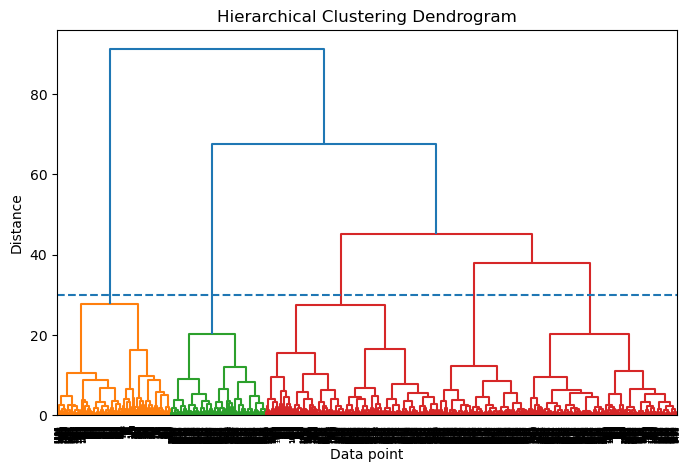

In [131]:
Z = linkage(scaled_df, method='ward')
# Plot the dendrogram
plt.figure(figsize=(8, 5))
dendrogram(Z, labels=scaled_df.index.tolist())  # Use labels from DataFrame index
plt.title('Hierarchical Clustering Dendrogram')
plt.axhline(30, linestyle='--')
plt.xlabel('Data point')
plt.ylabel('Distance')
plt.show()

In [144]:
from scipy.cluster.hierarchy import fcluster

# Cắt thành 3 cụm 
cluster_labels = fcluster(Z, 6, criterion='maxclust')

# Thêm vào DataFrame để dễ xem
scaled_df['Cluster'] = cluster_labels
scaled_df.columns = ['Recency_scaled','Frequency_scaled', 'Monetary_scaled', 'Cluster' ]


In [145]:
scaled_df.head()

,Recency_scaled,Frequency_scaled,Monetary_scaled,Cluster
0,-0.596823,2.743128,4.989973,2
1,-1.036843,2.285083,4.693873,2
2,-1.185772,2.743128,4.495566,2
3,-1.192542,3.430196,4.181536,2
4,-0.251577,1.368993,4.102757,2


In [146]:
scaled_df.groupby('Cluster')['Recency_scaled'].count()

Cluster
1     408
2     296
3     588
4    1068
5     547
6     923
Name: Recency_scaled, dtype: int64

In [147]:
df = pd.concat([df_rfm, scaled_df],axis=1)
df.head()

,Member_number,Recency,Frequency,Monetary,Recency_scaled,Frequency_scaled,Monetary_scaled,Cluster
0,2193,91,21,361.45,-0.596823,2.743128,4.989973,2.0
1,1793,26,19,345.10,-1.036843,2.285083,4.693873,2.0
2,3289,4,21,334.15,-1.185772,2.743128,4.495566,2.0
3,2433,3,24,316.81,-1.192542,3.430196,4.181536,2.0
4,2743,142,15,312.46,-0.251577,1.368993,4.102757,2.0


In [148]:
mean_values = df.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()

#calculate Count
count_values = df.groupby('Cluster')['Monetary'].count()

rfm_agg = mean_values.round(0)
rfm_agg['Monetary_count'] = count_values
rfm_agg.columns = ['RecencyMean', 'FrequencyMean', 'MonetaryMean', 'Count']
rfm_agg['Percent'] = round((rfm_agg['Count']/rfm_agg.Count.sum())*100, 2)


rfm_agg = rfm_agg.reset_index()
rfm_agg

,Cluster,RecencyMean,FrequencyMean,MonetaryMean,Count,Percent
0,1.0,90.0,14.0,132.0,408,10.65
1,2.0,99.0,16.0,212.0,296,7.73
2,3.0,270.0,5.0,36.0,588,15.35
3,4.0,186.0,9.0,87.0,1068,27.89
4,5.0,256.0,5.0,36.0,547,14.28
5,6.0,158.0,9.0,86.0,923,24.10


In [149]:
import plotly.express as px

fig = px.scatter(rfm_agg, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="Cluster",
           hover_name="Cluster", size_max = 60) 
fig.show()